In [1]:
from dataclasses import dataclass
import itertools
import logging
import random
import math
import numpy as np
import json
import pickle
import time
import torch
import sys
import yaml
import seaborn as sns
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from torch import nn, Tensor
from torch.nn import functional as F
from typing import List, Optional, Tuple

from ihead_data import DataArgs, Dataset, iterate_batches
from ihead_full_model import ModelArgs, Transformer

%load_ext autoreload
%autoreload 2


In [2]:
cfg = OmegaConf.load("/Users/guotianyu/GitHub/massive-tokens/birth/model_L2_H4_lr3-4/params.yaml")
model = Transformer(cfg.model_args)
model.eval()
state_path = "/Users/guotianyu/GitHub/massive-tokens/birth/model_L2_H4_lr3-4/state_4500.pt"
state = torch.load(state_path, map_location="cpu")
model.load_state_dict(state["model_state_dict"], strict=False)


<All keys matched successfully>

In [3]:
ds = Dataset(cfg.data_args, train_test=None)
ds_test = Dataset(cfg.data_args, train_test=None)
ds_test.idxs = ds.idxs
cfg.model_args.vocab_size = ds.num_tokens

In [4]:
x, outs = ds.gen_batch(rng=np.random.default_rng([42, 27]), batch_size=cfg.optim_args.batch_size)
(x, y, outs) = (x[:,:-1], x[:,1:], outs[:,:-1])
x = torch.from_numpy(x)
y = torch.from_numpy(y)
outs = torch.from_numpy(outs)

In [5]:
layer_idx = 1
scores = model.get_layer_scores(x, layer_idx)
scores.shape

torch.Size([512, 4, 256, 256])

In [6]:
import pickle
with open('/Users/guotianyu/GitHub/massive-tokens/birth/model_L2_H4_lr3-4/exp.pkl', 'rb') as f:
    data = pickle.load(f)

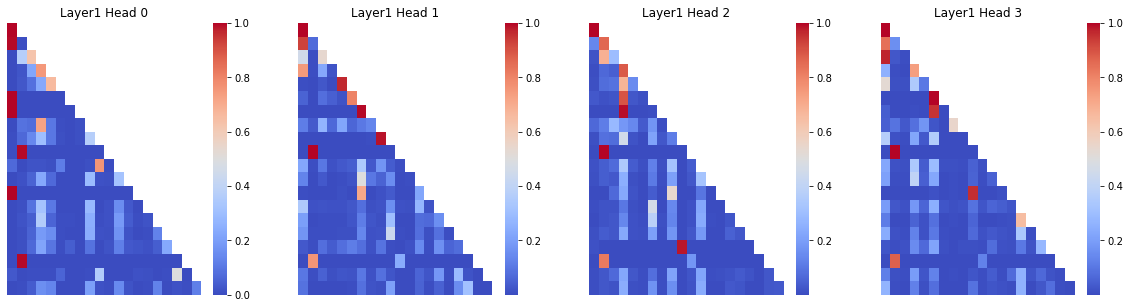

In [51]:
# scores = data['scores'][layer_idx]
seq_idx = 16
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes = axes.flatten()
for i, ax in enumerate(axes):
    attns = scores[seq_idx, i, :20, :20].detach().numpy()
    # attns = scores[0, i, :20, :20]
    mask = 1 - np.tril(np.ones_like(attns)) # manually impose causal mask for better-looking plots
    sns.heatmap(
            attns, mask=mask,
            cmap="coolwarm", xticklabels=False, yticklabels=False,
            ax=ax,
        )
    ax.set_title(f"Layer{layer_idx} Head {i}")
    # ax.set_xticks(list(ds.decode(x[seq_idx, :20].numpy())))
plt.show()

In [52]:
list(ds.decode(x[seq_idx, :20].numpy()))

[' ',
 '-',
 'p',
 'r',
 'v',
 'o',
 'a',
 '$',
 'l',
 ' ',
 '-',
 'n',
 't',
 'Q',
 'U',
 'S',
 ':',
 ' ',
 '-',
 'S']

In [48]:
ds.decode(ds.idxs)

'aote '

In [67]:
rng = np.random.Generator
seq += [rng.choice(self.tok_range, p=self.marginal)]
while len(seq) < self.seq_length + 1:
    last = seq[-1]
    if last in idxs:
        seq.append(outs[idxs.index(last)])
        if self.output_counter:
            cnts[last] = cnts.get(last, 0) + 1
            outputs_seq.append(cnts[last])
        else:
            outputs_seq.append(1)
    else:
        probs = self.cond[last]
        outputs_seq.append(0)
        seq.append(rng.choice(self.tok_range, p=probs))
outputs_seq.append(0)

None
